In [1]:
#import necessary libraries for regression analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import scipy.stats as stats
from sklearn.model_selection import train_test_split

import pylab
from modelCustomFunctions import create_ols, check_resid_distribution, check_features_vif, get_low_pval_features

### Custom Functions ###

In [2]:
df_preprocessed = pd.read_csv('Experiment1', index_col=0)
df_preprocessed.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,1800,7503


### Train-Test-Split

In [3]:
train, test = train_test_split(df_preprocessed, test_size=0.2, random_state=42)

In [4]:
print(len(train), len(test))

17136 4284


In [5]:
#Build baseline model
X = train.drop('price', axis=1)
formula = 'price~' + '+'.join(X.columns)

In [6]:
baseline = ols(formula=formula, data=train).fit()

In [7]:
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     2009.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:16:22   Log-Likelihood:            -2.3507e+05
No. Observations:               17136   AIC:                         4.702e+05
Df Residuals:                   17119   BIC:                         4.703e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.209e+06   3.56e+06      1.743      0.081   -7.73e+05    1.32e+07
bedrooms      -3.903e+04   2312.466    -16.879      0.000   -4.36e+04   -3.45e+04
bathrooms      4.569e+04   3969.523     11.509      0.000    3.79e+04    5.35e+04
sqft_living     119.3032     21.823      5.467      0.000      76.529     162.078
sqft_lot          0.0153      0.068      0.226      0.821      -0.117       0.148
floors         2.125e+04   4364.998      4.869      0.000    1.27e+04    2.98e+04
waterfront     5.881e+05   2.16e+04     27.166      0.000    5.46e+05     6.3e+05
view           4.286e+04   2596.267     16.508      0.000    3.78e+04    4.79e+04
condition      1.932e+04   2871.357      6.729      0.000    1.37e+04    2.49e+04
grade          1.235e+05   2568.225     48.089      0.000    1.18e+05    1.29e+05
sqft_above       40.4688     21.823      1.854      0.064      -2.306      83.244
sqft_basement    49.1509     21.645      2.271      0.023       6.724      91.578
yr_built      -3588.6489     84.090    -42.676      0.000   -3753.474   -3423.824
yr_renovated     19.0514      4.831      3.943      0.000       9.582      28.521
zipcode           0.0645     35.761      0.002      0.999     -70.030      70.159
sqft_living15    24.2933      4.156      5.845      0.000      16.147      32.440
sqft_lot15       -0.6079      0.100     -6.071      0.000      -0.804      -0.412
==============================================================================
Omnibus:                    13804.562   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1169680.232
Skew:                           3.311   Prob(JB):                         0.00
Kurtosis:                      42.929   Cond. No.                     2.13e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
features = df_preprocessed.columns.drop('price')

def check_homoskedasticity(model, df, target : "", features):
    
    """Input: 
    model: an sm.OLS model  
    df: a data frame
    target : a string 
    features: the features of the model 
    
    Retrun: 
    True if 
    False  
    Prints out P-value and F-statistic
    ------------------------
    Uses the Breusch–Pagan test. If p-value is below 0.05, then 
    the null hypothesis of homoskedasticity is rejected and 
    heteroskedasticity is assumed.
    """ 
    
    #Plot scatter plot
    y_hat = df[target] - model.predict(df[features])
            
    plt.scatter(model.predict(df[features]), y_hat, alpha = 0.2)
    plt.plot(model.predict(df[features]), [0 for i in range(len(df))])
    plt.show()

    #run Pegan test
    _, pval, _, f_pval = diag.het_breuschpagan(model.resid, model.model.exog)
    
    print('-'*50)
    print('The P-value is: {:.2}'.format(pval))
    print('The F-statistic is {:.2}'.format(f_pval))
    print('-'*50)
    
    if pval >= 0.05:
    
        print("The p-value is above 0.05, thus we fail to reject the null hypothesis of homoskedasticity")
        return True

    return False

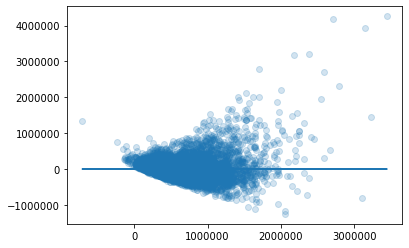

--------------------------------------------------
The P-value is: 0.0
The F-statistic is 0.0
--------------------------------------------------


False

In [9]:
#Check for Homoskedasticity
check_homoskedasticity(baseline, train, "price", features)

In [10]:
#Check for Multicollinearity 
check_features_vif(train, "price")

,VIF Factor,features
0,23.2,bedrooms
1,28.6,bathrooms
2,882.9,sqft_living
3,2.9,sqft_lot
4,16.7,floors
5,1.2,waterfront
6,1.5,view
7,34.5,condition
8,140.6,grade
9,663.4,sqft_above


['sqft_living',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'zipcode']

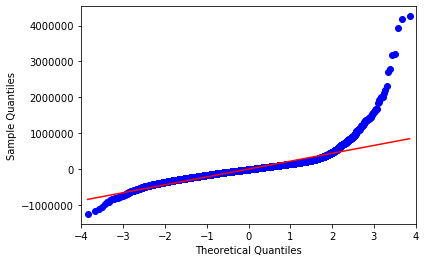

The mean of the residuals is: 2.4e-08. The closer to 0, the better.


In [11]:
#Check for Normality 
check_resid_distribution(baseline)

In [12]:
#Which features have p-values below 0.05 in our summary
get_low_pval_features(baseline)

['bathrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'sqft_living15',
 'sqft_lot15']

### Model 1: Log Transform Variables

Steps to improve the model:

1. We noticed there's heteroscedasticity in our data, we will attempt to fix that by log transforming highly skewed variables, such as **sqft_living**.

2. We also noticed that there's some among our features. To improve on that, we will **drop some features with a high variance inflation factor**: 

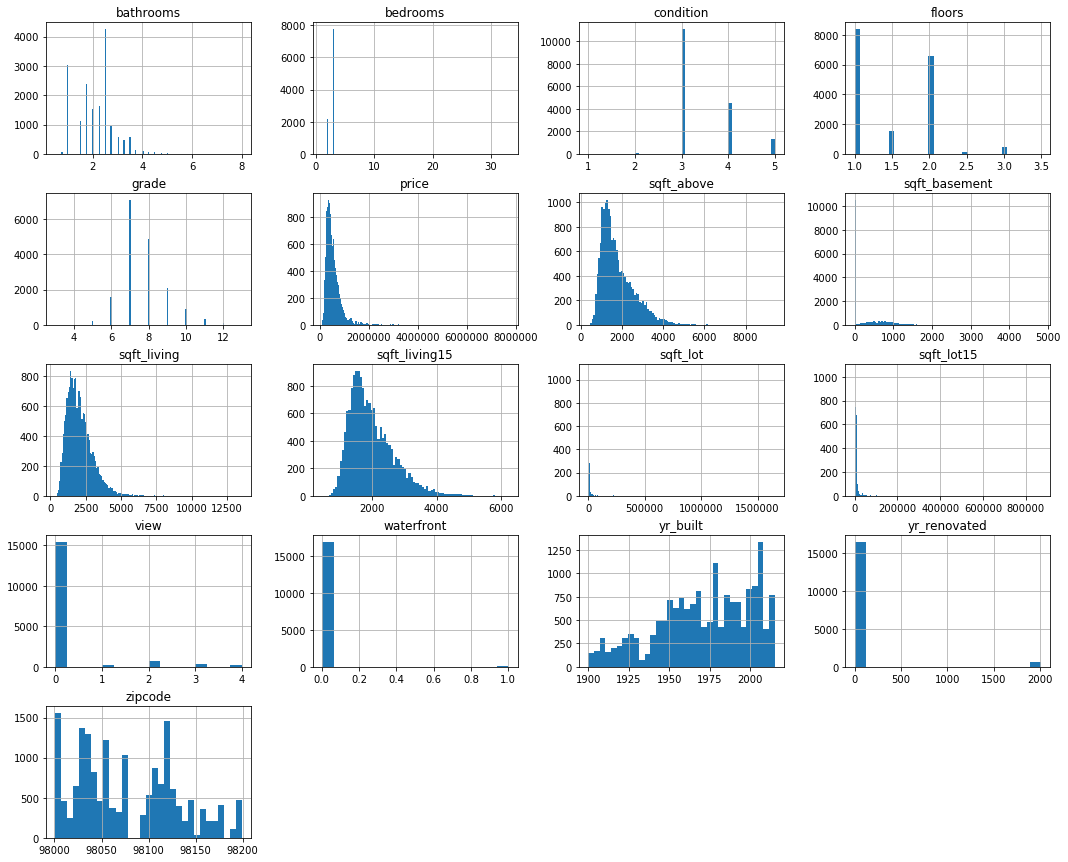

In [13]:
#explore variables for skewness 
train.hist(figsize=(18,15), bins='auto');

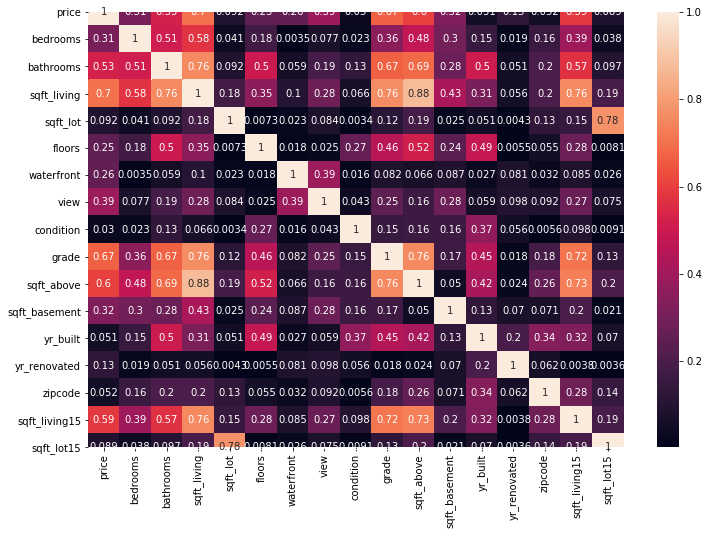

In [14]:
#explore features with high correlation 
corr = train.corr().abs()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True)
plt.show()

We see that sqft_living is highly correlated with sqft_above and sqft_living15, which we deem less relevant to our prediction. We will remove these two from the feature set. In addition, we'll log transform sqft_living.

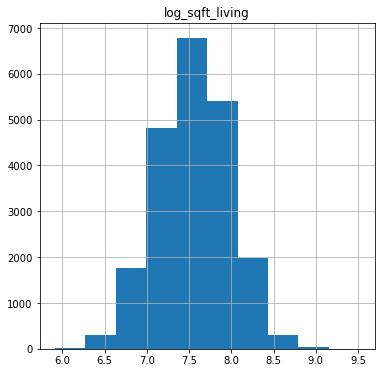

In [15]:
data_log = pd.DataFrame([])
data_log['log_sqft_living'] = np.log(df_preprocessed['sqft_living'])
data_log.hist(figsize  = [6, 6]);

In [16]:
# df_preprocessed = df_preprocessed.drop(columns = ["sqft_above", "sqft_living15", 'sqft_lot15', 'sqft_basement','sqft_living' ])

In [17]:
df_preprocessed = pd.concat([df_preprocessed, data_log], axis=1)

In [19]:
# floors_dummies = pd.get_dummies(df_preprocessed['floors_binned'], prefix='floors_binned', drop_first=True)
# view_dummies = pd.get_dummies(df_preprocessed['view'], prefix='view', drop_first=True)
# grade_dummies = pd.get_dummies(df_preprocessed['grade_binned'], prefix='grade_binned', drop_first=True)
# condition_dummies = pd.get_dummies(df_preprocessed['condition'], prefix='condition', drop_first=True)

# df_preprocessed = df_preprocessed.drop(['floors_binned', 'view', 'grade_binned', 'condition'], axis=1)
# df_preprocessed = pd.concat([df_preprocessed, floors_dummies, view_dummies, grade_dummies, condition_dummies], axis=1)
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 18 columns):
price              21420 non-null float64
bedrooms           21420 non-null int64
bathrooms          21420 non-null float64
sqft_living        21420 non-null int64
sqft_lot           21420 non-null int64
floors             21420 non-null float64
waterfront         21420 non-null float64
view               21420 non-null float64
condition          21420 non-null int64
grade              21420 non-null int64
sqft_above         21420 non-null int64
sqft_basement      21420 non-null float64
yr_built           21420 non-null int64
yr_renovated       21420 non-null float64
zipcode            21420 non-null int64
sqft_living15      21420 non-null int64
sqft_lot15         21420 non-null int64
log_sqft_living    21420 non-null float64
dtypes: float64(8), int64(10)
memory usage: 3.1 MB


In [ ]:
#Rename columns that contain '.' so that they will run properly through our regression model later
df_preprocessed.columns = df_preprocessed.columns.str.replace('.','_')

In [20]:
train2, test2 = train_test_split(df_preprocessed, test_size=0.2, random_state=42)

In [21]:
X = train2.drop('price', axis=1)
formula = 'price~' + '+'.join(X.columns)

In [22]:
model2 = ols(formula=formula, data=train2).fit()

In [23]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     2155.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:17:49   Log-Likelihood:            -2.3432e+05
No. Observations:               17136   AIC:                         4.687e+05
Df Residuals:                   17118   BIC:                         4.688e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.569e+07   3.42e+06      4.591      0.000    8.99e+06    2.24e+07
bedrooms        -1.433e+04   2300.064     -6.229      0.000   -1.88e+04   -9818.865
bathrooms        5.649e+04   3809.648     14.829      0.000     4.9e+04     6.4e+04
sqft_living       328.6797     21.550     15.252      0.000     286.439     370.920
sqft_lot            0.0027      0.065      0.041      0.967      -0.124       0.130
floors           3.457e+04   4191.962      8.248      0.000    2.64e+04    4.28e+04
waterfront       5.657e+05   2.07e+04     27.289      0.000    5.25e+05    6.06e+05
view             3.803e+04   2488.283     15.283      0.000    3.32e+04    4.29e+04
condition        2.657e+04   2754.710      9.644      0.000    2.12e+04     3.2e+04
grade            1.277e+05   2460.761     51.907      0.000    1.23e+05    1.33e+05
sqft_above         24.1265     20.894      1.155      0.248     -16.828      65.081
sqft_basement      56.7510     20.721      2.739      0.006      16.136      97.366
yr_built        -3290.4937     80.848    -40.700      0.000   -3448.963   -3132.024
yr_renovated       26.2989      4.628      5.682      0.000      17.227      35.371
zipcode           -67.2815     34.274     -1.963      0.050    -134.463      -0.100
sqft_living15      40.4974      4.000     10.126      0.000      32.658      48.337
sqft_lot15         -0.6260      0.096     -6.531      0.000      -0.814      -0.438
log_sqft_living -5.415e+05   1.37e+04    -39.549      0.000   -5.68e+05   -5.15e+05
==============================================================================
Omnibus:                    10000.033   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           408373.018
Skew:                           2.174   Prob(JB):                         0.00
Kurtosis:                      26.517   Cond. No.                     2.14e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
create_ols(train2)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     2155.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:17:57   Log-Likelihood:            -2.3432e+05
No. Observations:               17136   AIC:                         4.687e+05
Df Residuals:                   17118   BIC:                         4.688e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.569e+07   3.42e+06     

In [25]:
features2 = train2.columns.drop('price')

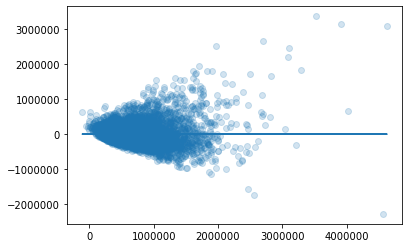

--------------------------------------------------
The P-value is: 0.0
The F-statistic is 0.0
--------------------------------------------------


False

In [26]:
check_homoskedasticity(model2, train2, 'price', features2)

In [27]:
import math

In [28]:
X = df_preprocessed.drop("price", axis=1)
Y = df_preprocessed[["price"]]  
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size= .20, random_state = 1)

In [29]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train2, y_train2)

y_hat_train2 = linreg.predict(X_train2)
y_hat_test2 = linreg.predict(X_test2)

In [30]:
from sklearn.metrics import mean_squared_error

train_mse2 = mean_squared_error(y_train2, y_hat_train2)
test_mse2 = mean_squared_error(y_test2, y_hat_test2)
print('Train Mean Squarred Error:', train_mse2)
print('Test Mean Squarred Error:', test_mse2)

print('Train Root Mean Squarred Error:', train_mse2**0.5)
print('Test Root Mean Squarred Error:', test_mse2**0.5)

Train Mean Squarred Error: 42755268891.2111
Test Mean Squarred Error: 44219548017.29371
Train Root Mean Squarred Error: 206773.47240690983
Test Root Mean Squarred Error: 210284.44549536638


In [ ]:
df_preprocessed['price'] = np.log(df_preprocessed['price'])

In [ ]:
train3, test3 = train_test_split(df_preprocessed, test_size=0.2, random_state=42)

In [ ]:
X = train3.drop('price', axis=1)
formula = 'price~' + '+'.join(X.columns)

In [ ]:
model3 = ols(formula=formula, data=train3).fit()

In [ ]:
model3.summary()

In [ ]:
df_preprocessed.drop(['sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'condition_2'], axis=1, inplace=True)

In [ ]:
df_preprocessed.drop(['condition_2'], axis=1, inplace=True)

In [ ]:
df_preprocessed.info()

In [ ]:
df_preprocessed.corr()

In [ ]:
train4, test4 = train_test_split(df_preprocessed, test_size=0.2, random_state=42)

In [ ]:
X = train4.drop('price', axis=1)
formula = 'price~' + '+'.join(X.columns)

In [ ]:
model4 = ols(formula=formula, data=train4).fit()

In [ ]:
model4.summary()

In [ ]:
#new feature: age

#df_preprocessed['age'] = df_preprocessed['yr_built'].apply(lambda x: 2015 - x)


##X = df_model2.drop("price", axis=1)
##Y = df_model2[["price"]]  
##X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= .20, random_state = 1 )
    
